In [31]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from qutip import (
    basis, mesolve, sigmax, sigmay, sigmaz, qeye, tensor, Options, expect, Qobj
)
from qutip import gates
from tqdm import tqdm # 用于显示进度条

# --- (字体配置与之前相同) ---
try:
    font_preferences = ['SimHei', 'Microsoft YaHei', 'WenQuanYi Micro Hei', 'PingFang SC', 'Noto Sans CJK SC']
    found_font = False
    for font_name in font_preferences:
        try:
            matplotlib.font_manager.findfont(font_name)
            plt.rcParams['font.sans-serif'] = [font_name]
            print(f"中文配置：成功设置字体为 {font_name}")
            found_font = True
            break
        except Exception:
            continue
    if not found_font:
        print("中文配置：未能找到并设置优先选择的中文字体。中文可能无法正确显示。")
    plt.rcParams['axes.unicode_minus'] = False
except Exception as e:
    print(f"设置Matplotlib字体参数时发生错误: {e}")

中文配置：成功设置字体为 SimHei


In [ ]:
# --- (Qobj 定义与之前相同) ---
g_state = basis(2, 0)
e_state = basis(2, 1)
ge = tensor(g_state, e_state)
eg = tensor(e_state, g_state)
sx1_op = tensor(sigmax(), qeye(2))
sy1_op = tensor(sigmay(), qeye(2))
sz1_op = tensor(sigmaz(), qeye(2))
sx2_op = tensor(qeye(2), sigmax())
sy2_op = tensor(qeye(2), sigmay())
sz2_op = tensor(qeye(2), sigmaz())
I4 = tensor(qeye(2), qeye(2))
sxsx_op = tensor(sigmax(), sigmax())
sysy_op = tensor(sigmay(), sigmay())
szsz_op = tensor(sigmaz(), sigmaz())
psi_p_single = (g_state + e_state).unit()
psi_p_initial = tensor(psi_p_single, psi_p_single)
rho_initial = psi_p_initial * psi_p_initial.dag()
psi_plus = (ge + eg).unit()
P_psi_plus_op = psi_plus * psi_plus.dag()
psi_minus = (ge - eg).unit()
P_psi_minus_op = psi_minus * psi_minus.dag()
P01_op = ge * ge.dag()
P10_op = eg * eg.dag()

# hopping算
SWAP_op = 0.5 * (I4 + sxsx_op + sysy_op + szsz_op)
# 完美Pi脉冲算符 (Y⊗Y)
# U_pi_Y_Y_pulse = tensor(sigmay(), sigmay())
# 不完美Pi脉冲算符 
theta = 0.99 * np.pi
U_pi_Y_Y_pulse = tensor(gates.ry(theta), gates.ry(theta)) 
print(U_pi_Y_Y_pulse)

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 2.46719817e-04 -1.57053795e-02 -1.57053795e-02  9.99753280e-01]
 [ 1.57053795e-02  2.46719817e-04 -9.99753280e-01 -1.57053795e-02]
 [ 1.57053795e-02 -9.99753280e-01  2.46719817e-04 -1.57053795e-02]
 [ 9.99753280e-01  1.57053795e-02  1.57053795e-02  2.46719817e-04]]


In [33]:
# --- 系统参数 ---
delta_drive_H = 1.0 * np.pi
H_drive_base = (delta_drive_H / 2.0) * (sz1_op + sz2_op)
delta_omega_DFS = 0.1 * np.pi
H_bias_DFS = (delta_omega_DFS / 2.0) * (P01_op - P10_op)
H_fixed_part = H_drive_base + H_bias_DFS

# --- 准静态集体噪声参数 ---
N_quasi_static_samples = 100 # 为测试速度可适当减小 (原为50)
sigma_quasi_static_noise_strength = 0.1 * np.pi
H_quasi_static_operator = (sz1_op + sz2_op) / 2.0

# --- Hopping 参数 ---
N_max_hops = 3 # 每条轨迹最大hopping次数
time_precision_epsilon = 1e-9 # 用于浮点数比较和避免时间点完全重合的精度

# --- Pi脉冲序列参数 ---
N_pi_pulses_setting = 31 # 回波序列中的pi脉冲数量 (0: 无脉冲类FID, 1: Hahn回波, >1: CPMG类)

# --- 其他退相干参数 (动态噪声) ---
gamma_collective_rate = 0.02
#DFE 相干时间1000s
gamma_DFS_dephasing_rate = 0.001

# --- 时间参数 ---
t_final = 45.0
n_points_total = 301 # 总时间点数，确保能覆盖所有事件
tlist_full = np.linspace(0, t_final, n_points_total)


# 全局计算Pi脉冲的时间点 (用于事件生成和绘图)
global_pi_pulse_times = []
if N_pi_pulses_setting > 0:
    # Pi脉冲将 (0, t_final) 分成 N_pi_pulses_setting + 1 段
    delta_t_segment_duration = t_final / (N_pi_pulses_setting + 1)
    for i_pulse_idx in range(1, N_pi_pulses_setting + 1): # 脉冲索引从1开始
        t_p = i_pulse_idx * delta_t_segment_duration
        # 确保脉冲不在t_final，以避免段结束问题
        if t_p < t_final - time_precision_epsilon:
            global_pi_pulse_times.append(t_p)
        # 对于单脉冲Hahn回波，如果计算出的时间非常接近t_final/2，则强制设为t_final/2
        elif N_pi_pulses_setting == 1 and np.isclose(t_p, t_final/2.0):
             global_pi_pulse_times.append(t_final/2.0)
# 确保global_pi_pulse_times中的时间点也存在于tlist_full中，以便绘图和数据提取
if global_pi_pulse_times:
    tlist_full = np.unique(np.sort(np.concatenate([tlist_full, global_pi_pulse_times])))


# --- QuTiP 选项 ---
# 增加nsteps，为更精细的演化段提供可能性，atol/rtol控制精度
qutip_options_segmented_evo = Options(store_states=True, nsteps=10000, atol=1e-8, rtol=1e-6, max_step=t_final/200)


# --- 期望算符列表 ---
e_ops_to_track = [
    sx1_op, sy1_op, sz1_op, sx2_op, sy2_op, sz2_op,
    P_psi_plus_op, P_psi_minus_op, sxsx_op, sysy_op, szsz_op,
    P01_op, P10_op
]
num_e_ops = len(e_ops_to_track)

# --- 塌缩算符 ---
c_ops_dynamic = []
if gamma_collective_rate > 0:
    c_ops_dynamic.append(np.sqrt(gamma_collective_rate) * (sz1_op + sz2_op))
if gamma_DFS_dephasing_rate > 0:
    c_ops_dynamic.append(np.sqrt(gamma_DFS_dephasing_rate) * (sz1_op - sz2_op))

C:\Users\pjhse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip\solver\options.py:16: FutureWarning: Dedicated options class are no longer needed, options should be passed as dict to solvers.
  warnings.warn(


In [34]:
# --- 分段演化函数 (run_path_simulation) ---
# (此函数与上一步骤中提供的版本基本相同，细节处做了健壮性调整)
def run_path_simulation(H_const, rho_start_state, full_tlist_global, c_ops_list,
                        e_ops_list_global, events_this_path, qutip_options_cfg):
    current_rho = rho_start_state
    path_expects = [np.zeros_like(full_tlist_global, dtype=float) for _ in e_ops_list_global]

    # 确保在 full_tlist_global 的 t=0 处，期望值被正确初始化
    if np.isclose(full_tlist_global[0], 0.0):
        for op_idx, op in enumerate(e_ops_list_global):
            path_expects[op_idx][0] = expect(op, rho_start_state)

    event_times_only = [evt['time'] for evt in events_this_path]
    all_segment_boundaries = np.unique(np.sort(np.concatenate(
        ([full_tlist_global[0]], event_times_only, [full_tlist_global[-1]])
    )))
    
    all_segment_boundaries = all_segment_boundaries[
        (all_segment_boundaries >= full_tlist_global[0] - time_precision_epsilon) &
        (all_segment_boundaries <= full_tlist_global[-1] + time_precision_epsilon)
    ]
    if not np.isclose(all_segment_boundaries[0], full_tlist_global[0]):
        all_segment_boundaries = np.insert(all_segment_boundaries, 0, full_tlist_global[0])
    if not np.isclose(all_segment_boundaries[-1], full_tlist_global[-1]):
        all_segment_boundaries = np.append(all_segment_boundaries, full_tlist_global[-1])
    all_segment_boundaries = np.unique(all_segment_boundaries)


    for i in range(len(all_segment_boundaries) - 1):
        t_seg_start = all_segment_boundaries[i]
        t_seg_end = all_segment_boundaries[i+1]

        if t_seg_end - t_seg_start < time_precision_epsilon / 10: # 极短或零长度段
            # 即使段长为零，也需要处理位于此精确时间点的事件
            for event in events_this_path:
                if np.isclose(event['time'], t_seg_start, atol=time_precision_epsilon):
                    if event['type'] == 'unitary':
                        current_rho = event['op'] * current_rho * event['op'].dag()
            # 更新此时间点的期望值 (如果 full_tlist_global 中包含此点)
            idx_in_full_tlist = np.where(np.isclose(full_tlist_global, t_seg_start, atol=time_precision_epsilon/2))[0]
            if len(idx_in_full_tlist) > 0:
                for op_idx_global_inner, op_global_inner in enumerate(e_ops_list_global):
                    path_expects[op_idx_global_inner][idx_in_full_tlist[0]] = expect(op_global_inner, current_rho)
            continue

        # 为mesolve准备当前段的时间列表 (相对时间)
        strict_interior_indices = np.where(
            (full_tlist_global > t_seg_start + time_precision_epsilon) &
            (full_tlist_global < t_seg_end - time_precision_epsilon)
        )[0]
        
        times_for_mesolve_abs = [t_seg_start]
        if len(strict_interior_indices) > 0:
            times_for_mesolve_abs.extend(full_tlist_global[strict_interior_indices])
        times_for_mesolve_abs.append(t_seg_end)
        times_for_mesolve_abs = np.unique(np.sort(times_for_mesolve_abs))
        
        # 再次精炼和确保边界
        times_for_mesolve_abs = times_for_mesolve_abs[
            (times_for_mesolve_abs >= t_seg_start - time_precision_epsilon) &
            (times_for_mesolve_abs <= t_seg_end + time_precision_epsilon)
        ]
        # 确保段的起始点和结束点包含在内
        if not times_for_mesolve_abs.size or times_for_mesolve_abs[0] > t_seg_start + time_precision_epsilon:
            times_for_mesolve_abs = np.insert(times_for_mesolve_abs, 0, t_seg_start)
        else:
            times_for_mesolve_abs[0] = t_seg_start

        if times_for_mesolve_abs[-1] < t_seg_end - time_precision_epsilon:
            times_for_mesolve_abs = np.append(times_for_mesolve_abs, t_seg_end)
        else:
            times_for_mesolve_abs[-1] = t_seg_end
        times_for_mesolve_abs = np.unique(times_for_mesolve_abs) # 最终去重排序

        times_for_mesolve_rel = times_for_mesolve_abs - t_seg_start
        times_for_mesolve_rel[times_for_mesolve_rel < 0] = 0 #修正可能的负值
        times_for_mesolve_rel = np.unique(times_for_mesolve_rel) #再次去重排序


        if len(times_for_mesolve_rel) <= 1 and (len(times_for_mesolve_rel)==0 or np.isclose(times_for_mesolve_rel[-1], 0.0)): # 零时长演化
             result_segment_states = [current_rho] # 状态不变
             result_segment_expect_raw = [np.array([expect(op, current_rho)]) for op in e_ops_list_global]
        else:
            result_segment = mesolve(H_const, current_rho, times_for_mesolve_rel,
                                     c_ops_list, e_ops_list_global, options=qutip_options_cfg)
            result_segment_states = result_segment.states
            result_segment_expect_raw = result_segment.expect
        
        # 将此段的期望值结果填充到总的 path_expects 数组中
        for op_idx_global in range(len(e_ops_list_global)):
            data_from_segment_expect = result_segment_expect_raw[op_idx_global]
            for t_idx_in_segment_list, t_abs_val_in_seg_list in enumerate(times_for_mesolve_abs):
                match_indices = np.where(np.isclose(full_tlist_global, t_abs_val_in_seg_list, atol=time_precision_epsilon/2))[0]
                if len(match_indices) > 0:
                    target_output_idx = match_indices[0]
                    path_expects[op_idx_global][target_output_idx] = data_from_segment_expect[t_idx_in_segment_list]
        
        current_rho = result_segment_states[-1] # 更新当前密度矩阵为段末状态

        # 在段末应用所有恰好发生在该时间点的幺正事件
        for event in events_this_path:
            if np.isclose(event['time'], t_seg_end, atol=time_precision_epsilon):
                if event['type'] == 'unitary':
                    current_rho = event['op'] * current_rho * event['op'].dag()
                    # 事件发生后，立即更新该时间点的期望值 (如果 full_tlist_global 中包含此点)
                    idx_in_full_tlist_event = np.where(np.isclose(full_tlist_global, t_seg_end, atol=time_precision_epsilon/2))[0]
                    if len(idx_in_full_tlist_event) > 0:
                         for op_idx_global_event, op_global_event in enumerate(e_ops_list_global):
                            path_expects[op_idx_global_event][idx_in_full_tlist_event[0]] = expect(op_global_event, current_rho)
    return path_expects

In [35]:
# --- 初始化存储平均期望值的数组 ---
avg_result_no_pulses_expect = [np.zeros_like(tlist_full, dtype=float) for _ in range(num_e_ops)]
avg_results_with_pulses_expect = [np.zeros_like(tlist_full, dtype=float) for _ in range(num_e_ops)]

print(f"开始模拟，包含 {N_quasi_static_samples} 个准静态噪声样本, 最多 {N_max_hops} 次hopping...")
print(f"“有脉冲”序列将使用 {N_pi_pulses_setting} 个 pi ({U_pi_Y_Y_pulse.dims[0][0]}x{U_pi_Y_Y_pulse.dims[0][0]} Y⊗Y) 脉冲。")
if N_pi_pulses_setting > 0:
    print(f"Pi脉冲全局设定时间点: {[float(f'{tp:.3f}') for tp in global_pi_pulse_times]}")


for k_sample in tqdm(range(N_quasi_static_samples), desc="准静态噪声采样"):
    epsilon_k = np.random.normal(0, sigma_quasi_static_noise_strength)
    H_total_current_sample = H_fixed_part + epsilon_k * H_quasi_static_operator

    # 为当前样本生成随机hopping时间
    num_actual_hops = np.random.randint(0, N_max_hops + 1)
    # 确保hopping不与pi脉冲精确重合 (简化事件处理，尽管不太可能)
    hop_times_k_raw = np.sort(np.random.uniform(0 + time_precision_epsilon, t_final - time_precision_epsilon, num_actual_hops))
    hop_times_k = []
    for t_hop_cand in hop_times_k_raw:
        is_far_from_pulses = True
        for t_pulse_check in global_pi_pulse_times:
            if np.isclose(t_hop_cand, t_pulse_check, atol=time_precision_epsilon*10): # 稍宽容的检查
                is_far_from_pulses = False
                break
        if is_far_from_pulses:
            hop_times_k.append(t_hop_cand)
    hop_times_k = np.array(hop_times_k)


    # --- 路径 1: 无Pi脉冲 (类似FID，但包含hopping) ---
    events_no_pulses = []
    for t_hop in hop_times_k:
        events_no_pulses.append({'time': t_hop, 'type': 'unitary', 'op': SWAP_op})
    events_no_pulses.sort(key=lambda x: x['time']) # 按时间排序事件

    expects_no_pulses_k = run_path_simulation(
        H_total_current_sample, rho_initial, tlist_full, c_ops_dynamic,
        e_ops_to_track, events_no_pulses, qutip_options_segmented_evo
    )
    for i in range(num_e_ops):
        avg_result_no_pulses_expect[i] += expects_no_pulses_k[i]

    # --- 路径 2: 使用 N_pi_pulses_setting 个Pi脉冲 (回波序列，包含hopping) ---
    events_with_pulses = []
    for t_hop in hop_times_k: # 添加SWAP hops
        events_with_pulses.append({'time': t_hop, 'type': 'unitary', 'op': SWAP_op})

    for t_p in global_pi_pulse_times: # 添加Pi脉冲
        events_with_pulses.append({'time': t_p, 'type': 'unitary', 'op': U_pi_Y_Y_pulse})
    events_with_pulses.sort(key=lambda x: x['time']) # 按时间排序所有事件

    expects_with_pulses_k = run_path_simulation(
        H_total_current_sample, rho_initial, tlist_full, c_ops_dynamic,
        e_ops_to_track, events_with_pulses, qutip_options_segmented_evo
    )
    for i in range(num_e_ops):
        avg_results_with_pulses_expect[i] += expects_with_pulses_k[i]

# --- 计算平均值 ---
for i in range(num_e_ops):
    avg_result_no_pulses_expect[i] /= N_quasi_static_samples
    avg_results_with_pulses_expect[i] /= N_quasi_static_samples

print("所有模拟和平均完成。")

开始模拟，包含 100 个准静态噪声样本, 最多 3 次hopping...
“有脉冲”序列将使用 31 个 pi (2x2 Y⊗Y) 脉冲。
Pi脉冲全局设定时间点: [1.406, 2.812, 4.219, 5.625, 7.031, 8.438, 9.844, 11.25, 12.656, 14.062, 15.469, 16.875, 18.281, 19.688, 21.094, 22.5, 23.906, 25.312, 26.719, 28.125, 29.531, 30.938, 32.344, 33.75, 35.156, 36.562, 37.969, 39.375, 40.781, 42.188, 43.594]


准静态噪声采样:   0%|          | 0/100 [00:00<?, ?it/s]C:\Users\pjhse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\qutip\solver\solver_base.py:576: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
准静态噪声采样: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]

所有模拟和平均完成。


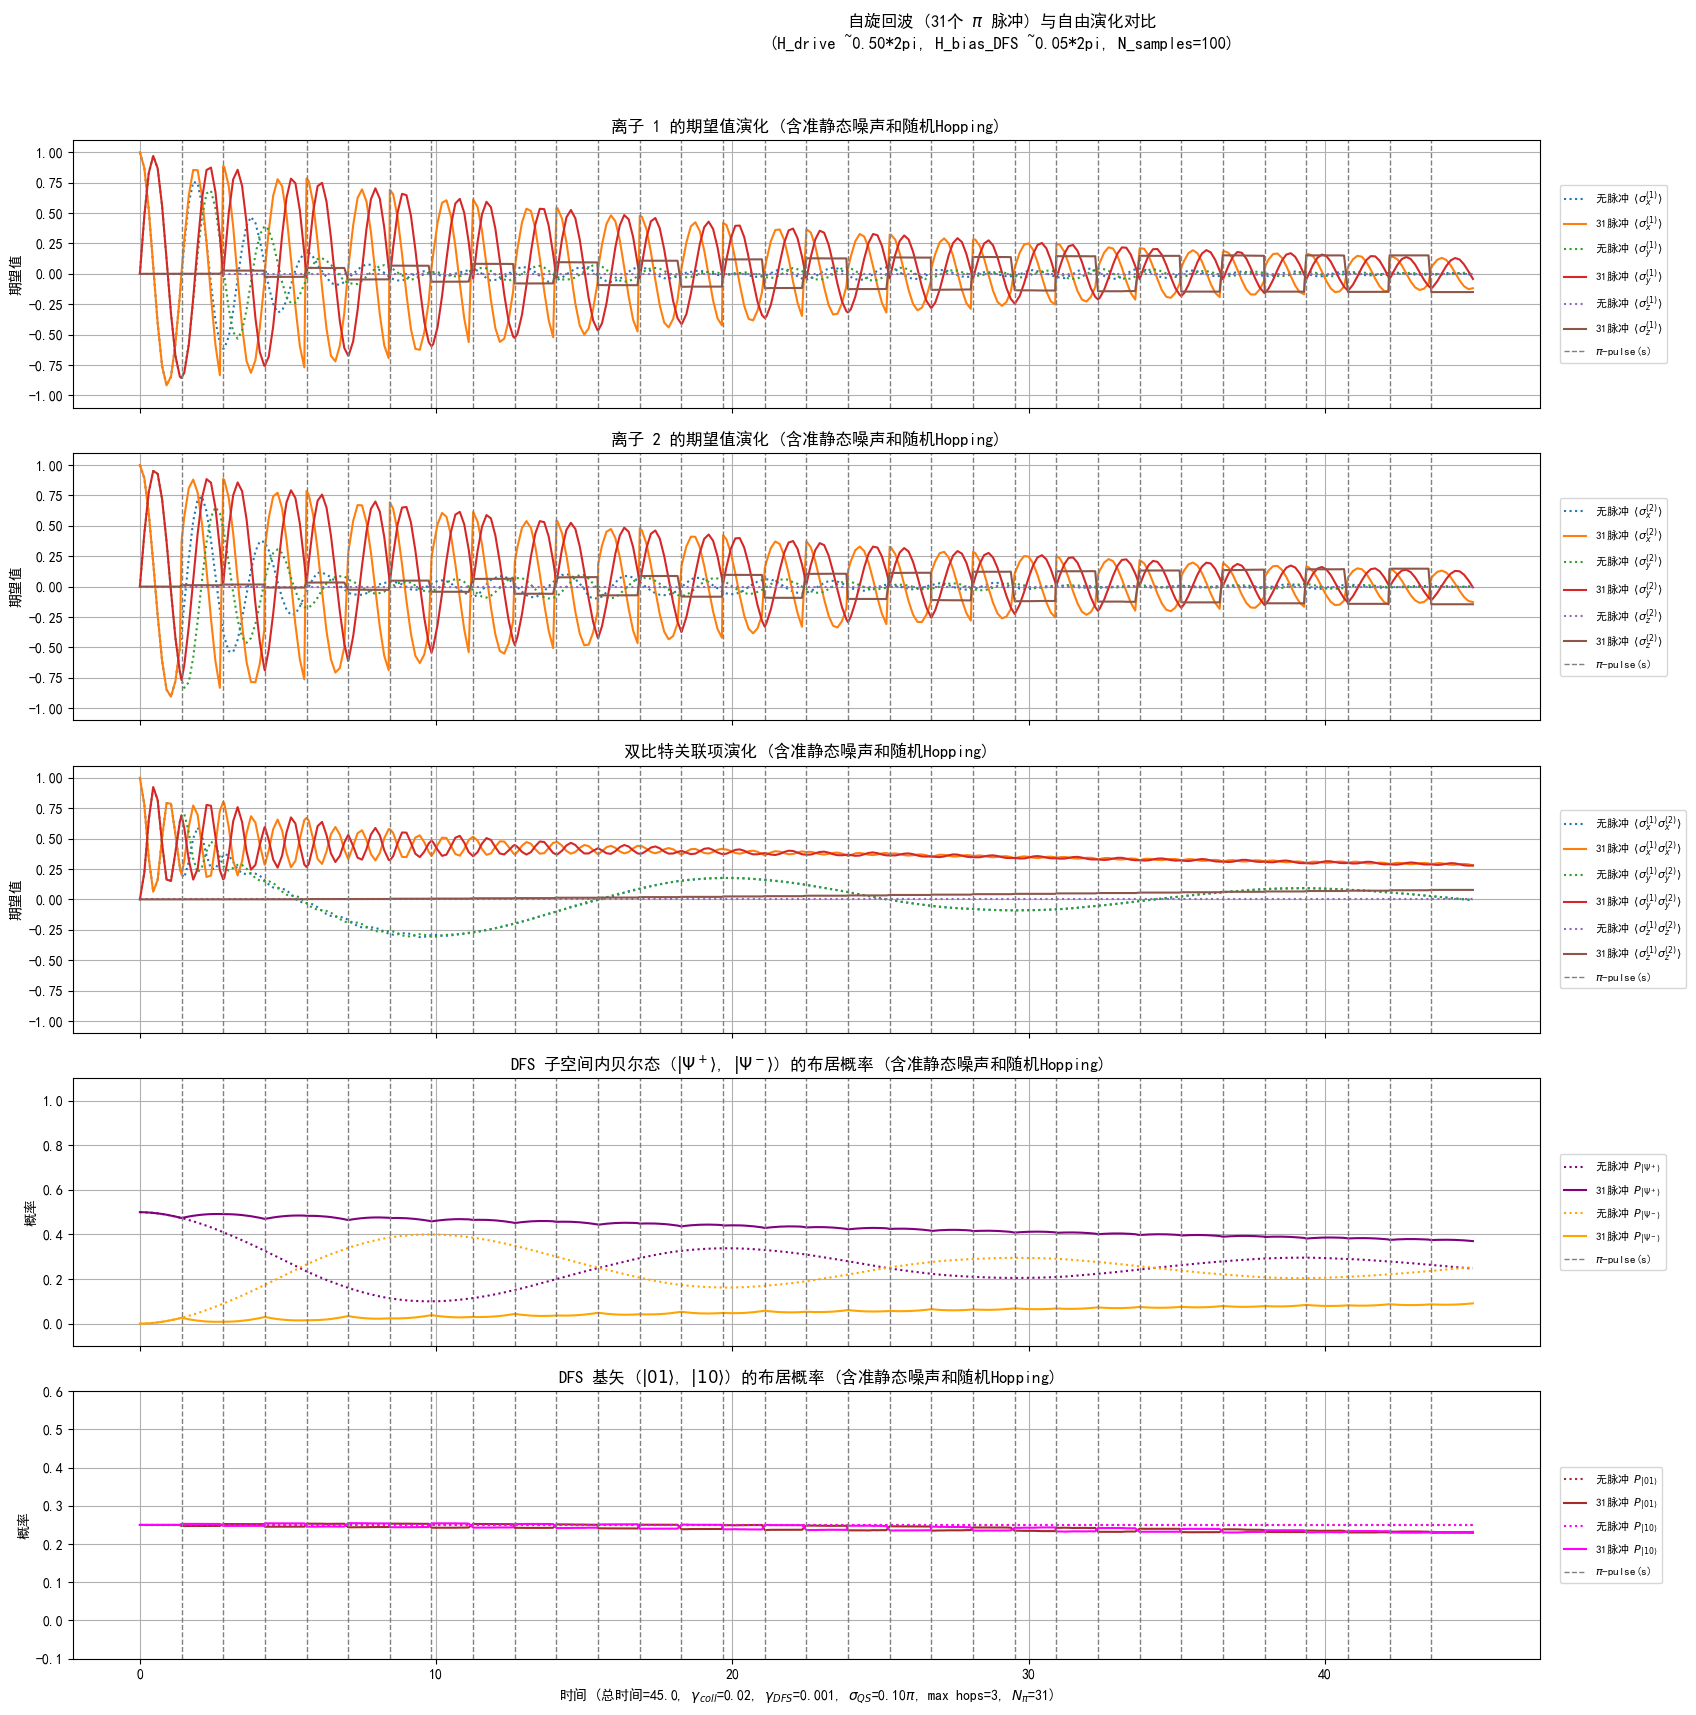


--- 期望值检查 (t=0, 基于平均结果) ---
初始 <sx1>: 无脉冲=1.0000, 有脉冲=1.0000 (理论: 1.0000)
初始 <sy1>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 <sz1>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 <sx2>: 无脉冲=1.0000, 有脉冲=1.0000 (理论: 1.0000)
初始 <sy2>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 <sz2>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 P(Psi+): 无脉冲=0.5000, 有脉冲=0.5000 (理论: 0.5000)
初始 P(Psi-): 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 <sxsx>: 无脉冲=1.0000, 有脉冲=1.0000 (理论: 1.0000)
初始 <sysy>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 <szsz>: 无脉冲=0.0000, 有脉冲=0.0000 (理论: 0.0000)
初始 P01: 无脉冲=0.2500, 有脉冲=0.2500 (理论: 0.2500)
初始 P10: 无脉冲=0.2500, 有脉冲=0.2500 (理论: 0.2500)


In [37]:
# --- 绘图 ---
fig, axes = plt.subplots(5, 1, figsize=(20, 18), sharex=True)
plot_linewidth = 1.5
plot_linestyle_no_pulses = ':'
plot_linestyle_with_pulses = '-'
pulse_line_color = 'gray'

# LaTeX字符串定义 (与之前相同)
tex_sx1 = r"$\langle \sigma_x^{(1)} \rangle$"
tex_sy1 = r"$\langle \sigma_y^{(1)} \rangle$"
tex_sz1 = r"$\langle \sigma_z^{(1)} \rangle$"
tex_sx2 = r"$\langle \sigma_x^{(2)} \rangle$"
tex_sy2 = r"$\langle \sigma_y^{(2)} \rangle$"
tex_sz2 = r"$\langle \sigma_z^{(2)} \rangle$"
tex_sxsx = r"$\langle \sigma_x^{(1)}\sigma_x^{(2)} \rangle$"
tex_sysy = r"$\langle \sigma_y^{(1)}\sigma_y^{(2)} \rangle$"
tex_szsz = r"$\langle \sigma_z^{(1)}\sigma_z^{(2)} \rangle$"
tex_P_psi_plus = r"$P_{|\Psi^+\rangle}$"
tex_P_psi_minus = r"$P_{|\Psi^-\rangle}$"
tex_P01 = r"$P_{|01\rangle}$"
tex_P10 = r"$P_{|10\rangle}$"

# 绘图配置: [算符索引列表, 算符LaTeX标签列表, 子图标题, (可选)颜色列表]
plot_configurations = [
    ([0, 1, 2], [tex_sx1, tex_sy1, tex_sz1], '离子 1 的期望值演化'),
    ([3, 4, 5], [tex_sx2, tex_sy2, tex_sz2], '离子 2 的期望值演化'),
    ([8, 9, 10], [tex_sxsx, tex_sysy, tex_szsz], '双比特关联项演化'),
    ([6, 7], [tex_P_psi_plus, tex_P_psi_minus], r'DFS 子空间内贝尔态 ($|\Psi^+\rangle$, $|\Psi^-\rangle$) 的布居概率', ['purple', 'orange']),
    ([11, 12], [tex_P01, tex_P10], r'DFS 基矢 ($|01\rangle$, $|10\rangle$) 的布居概率', ['brown', 'magenta'])
]
plot_y_axis_labels = ['期望值', '期望值', '期望值', '概率', '概率']
plot_y_axis_limits = [[-1.1, 1.1], [-1.1, 1.1], [-1.1, 1.1], [-0.1, 1.1], [-0.1, 0.6]]


for i_ax, config in enumerate(plot_configurations):
    ax = axes[i_ax]
    op_indices, op_labels_tex, title_base = config[0], config[1], config[2]
    custom_line_colors = config[3] if len(config) > 3 else None

    for i_op_local, op_idx_global in enumerate(op_indices):
        label_no_p = f'无脉冲 {op_labels_tex[i_op_local]}'
        label_with_p = f'{N_pi_pulses_setting}脉冲 {op_labels_tex[i_op_local]}'
        
        current_color = None
        if custom_line_colors:
            current_color = custom_line_colors[i_op_local % len(custom_line_colors)]
        # else: default matplotlib color cycle will be used

        ax.plot(tlist_full, avg_result_no_pulses_expect[op_idx_global],
                label=label_no_p, linestyle=plot_linestyle_no_pulses,
                linewidth=plot_linewidth, color=current_color)
        ax.plot(tlist_full, avg_results_with_pulses_expect[op_idx_global],
                label=label_with_p, linestyle=plot_linestyle_with_pulses,
                linewidth=plot_linewidth, color=current_color)

    if N_pi_pulses_setting > 0 and global_pi_pulse_times:
        for i_pulse_line, t_p_val in enumerate(global_pi_pulse_times):
            ax.axvline(t_p_val, color=pulse_line_color, linestyle='--', linewidth=1.0,
                       label='$\pi$-pulse(s)' if i_pulse_line == 0 else None) 

    ax.set_title(f'{title_base} (含准静态噪声和随机Hopping)')
    ax.set_ylabel(plot_y_axis_labels[i_ax])
    ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1.01, 0.5))
    ax.grid(True)
    ax.set_ylim(plot_y_axis_limits[i_ax])

axes[-1].set_xlabel(
    f'时间 (总时间={t_final:.1f}, $\gamma_{{coll}}$={gamma_collective_rate}, '
    f'$\gamma_{{DFS}}$={gamma_DFS_dephasing_rate}, '
    f'$\sigma_{{QS}}$={sigma_quasi_static_noise_strength/(np.pi):.2f}$\pi$, '
    f'max hops={N_max_hops}, $N_{{\pi}}$={N_pi_pulses_setting})'
)
fig.suptitle(
    f'自旋回波 ({N_pi_pulses_setting}个 $\pi$ 脉冲) 与自由演化对比\n'
    f'(H_drive ~{delta_drive_H/(2*np.pi):.2f}*2pi, '
    f'H_bias_DFS ~{delta_omega_DFS/(2*np.pi):.2f}*2pi, '
    f'N_samples={N_quasi_static_samples})', fontsize=12
)
plt.tight_layout(rect=[0, 0.03, 0.85, 0.96])
plt.show()

# --- 期望值检查 (t=0, 基于平均结果) ---
print("\n--- 期望值检查 (t=0, 基于平均结果) ---")
op_names_for_check = [
    "<sx1>", "<sy1>", "<sz1>", "<sx2>", "<sy2>", "<sz2>",
    "P(Psi+)", "P(Psi-)", "<sxsx>", "<sysy>", "<szsz>",
    "P01", "P10"
]
rho_initial_for_check = psi_p_initial * psi_p_initial.dag()
theory_initial_values_calc = [expect(op, rho_initial_for_check) for op in e_ops_to_track]

for i, name in enumerate(op_names_for_check):
    sim_val_t0_no_p = avg_result_no_pulses_expect[i][0]
    sim_val_t0_with_p = avg_results_with_pulses_expect[i][0]
    theory_val = theory_initial_values_calc[i]
    print(f"初始 {name}: 无脉冲={sim_val_t0_no_p:.4f}, 有脉冲={sim_val_t0_with_p:.4f} (理论: {theory_val:.4f})")